<a href="https://colab.research.google.com/github/maciejskorski/ml_examples/blob/master/Predicting_HeartDisease.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Summary
 **What are most important risk factors for heart diseases?** We answer this question using
the Cleveland UC Irvine challenge, which asks to predict a heart disease based on 13 predictors (both numeric and categorical):
age, sex, chest pain symptoms, blood press,	cholesterol, blood sugar, rest ecg,	max heart rate,	exercise angina,	peak and slope on ecg, blocked vessels and	thallium test. This setup has been discussed many times as a toy or research problem, but this analysis prioritizes *robustness* to mitigate the selection bias (rarely addressed in other discussions).  

In [ ]:
#@title Preprocessing 
#@markdown  6 rows with missing data was skipped, leaving 297 partient records. The original names were changed to be more descriptive and different disease variants were merged into one (hdisease).   
import pandas as pd
_=!curl "https://archive.ics.uci.edu/ml/machine-learning-databases/heart-disease/processed.cleveland.data" -o "data.csv"
df=pd.read_csv('data.csv',header=None,skiprows=0)
df.columns = ['age','sex','chestpain','rest_bloodpress','cholesterol','bloodsugar','restecg','maxhrate','exangina','oldpeak','slope','blockedvessels','thallium','hdisease']
# convert target (different deases are encoded)
df['hdisease'] = df['hdisease']>0
# drop few rows with NA values
df=df.drop(df.index[(df=='?').any(1)],axis=0)
# force types
df['blockedvessels'] = df['blockedvessels'].astype('float')
df['thallium'] = df['thallium'].astype('float')
# give meaningful labels
#encoder = {1:'typ_angin',2:'atyp_angin',3:'non-angin',4:'asymptom'}
#df['chestpain'] = df['chestpain'].astype('int').apply(encoder.get)
#encoder = {1:'up',2:'flat',3:'down'}
#df['slope'] = df['slope'].astype('int').apply(encoder.get)
#encoder = {3:'norm',6:'fixed',7:'reversible'}
#df['thallium'] = df['thallium'].astype('int').apply(encoder.get)
#encoder = {0:'norm',1:'abnorm',2:'hypertrophy_evidence'}
#df['restecg'] = df['restecg'].astype('int').apply(encoder.get)
# show rows
#df.head()
#print(df.head().to_markdown())
#from IPython.display import display, HTML
#display(HTML(df.head().to_html()))

## Feature Selection

**Model**: Random Forest (parameters adjusted to avoid overly complex trees) was used to estimate the importance of features. Rather than fitting it on the whole data, this solution cross-validates it to minimize the selection bias (interval estimates for importances)

**Conclusions** thallium test, blocked vessels, chest pains, exercise angina and certain ecg patterns are major contributting factors. These detailed diagnostics and symptoms are ranked higher than more general (age, sex) or causal (sugar level) predictors. Some of the ecg metrics have low importance, maybe they are overprovisioned?

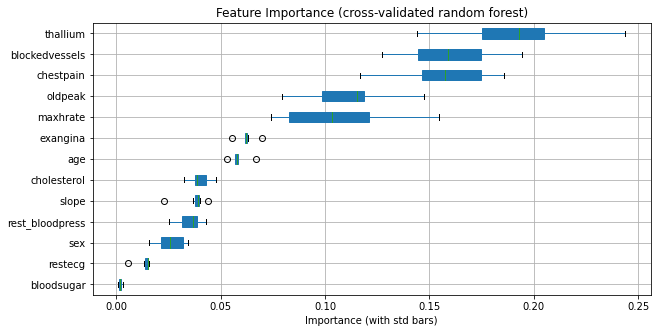

In [ ]:
#@title Random Forest Model (Cross-Validated)
from sklearn.metrics import make_scorer,roc_auc_score
from sklearn.feature_selection import RFECV,SelectFromModel
from sklearn.model_selection import cross_val_score,StratifiedKFold,cross_validate
from sklearn.ensemble import RandomForestClassifier
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt

y = df['hdisease']
X = df[df.columns[:-1]]
model = RandomForestClassifier(n_estimators=200,max_depth=5,min_samples_leaf=5,random_state=13)
cv = StratifiedKFold(5,shuffle=True,random_state=13)
out = cross_validate(model,X,y,scoring='f1',cv=cv,return_estimator=True)

ranks = []
for m in out['estimator']:
  ranks.append(pd.Series(m.feature_importances_,index=X.columns))
ranks = pd.DataFrame(ranks).T
ranks['score'] = ranks.mean(1)
ranks = ranks.sort_values('score',ascending=True)
fig,ax = plt.subplots(figsize=(10,5))
ranks.T.boxplot(vert=False,figsize=(14,10),patch_artist=True,ax=ax)
ax.set_title('Feature Importance (cross-validated random forest)')
ax.set_xlabel('Importance (with std bars)')
plt.show()

## Generalized Linear Model (BIC Selection)

**Model** <emph>Recursive Feature Elimination</emph> is used with Logistic Regression as the building block and Bayesian Information Criterion as the overfitting measure; in every round the least significant feature with p-value>0.10 is deleted. The model was *optimized by introducing non-linearity* in form of "breaking points" at "extreme" levels of cholesterol, blood presure, age, heart rate etc.

**Conclusions** The strongest impact (by sigificance) comes as before from blocked vessels, chest pain (4=atypical), heart rate, thalllium. However this time age, sex and cholesterol are important. This may due to the protective estrogen impact, but why this was not seen in the previous model?

In [ ]:
#@title Logistic Regression
X_onehot = X.copy(deep=True)

cat_vars = ['sex','chestpain','restecg','bloodsugar','exangina','slope','thallium']
vals = []
names = []
for c in cat_vars:
  val = pd.get_dummies(X_onehot[c])
  val.columns = list(map(str,val.columns))
  X_onehot = X_onehot.drop(c,axis=1)
  val = val[list(val.columns)[1:]]
  val.columns = list(map(lambda x: c+str(x),val.columns))
  vals.append(val)

X_onehot = pd.concat([X_onehot,pd.concat(vals,axis=1)],axis=1)
X_onehot['age>55'] = (X_onehot['age']>57).astype('float')
X_onehot['cholesterol>275'] = (X_onehot['cholesterol']>275).astype('float')
X_onehot['rest_bloodpress>150'] = (X_onehot['rest_bloodpress'] > 150).astype('float')
X_onehot['maxhrate>187'] = (X_onehot['maxhrate'] > 170).astype('float')

import statsmodels.api as sm
import statsmodels.formula.api  as smf
from statsmodels.tools import eval_measures

ftrs = list(X_onehot.columns)
outs = []

end = False
while not end:
  model = sm.GLM(exog=X_onehot[ftrs], endog=y.astype(int), family=sm.families.Binomial())
  model = model.fit()
  worst = model.pvalues.argmax(-1)
  if model.pvalues[worst] > 0.10:
    outs.append((ftrs[worst],eval_measures.bic(model.llf,model.nobs,model.df_model)))
    ftrs.remove(ftrs[worst])
  else:
    end = True

_=print(model.summary().tables[1])
print('start BIC=%s,end BIC=%s'%(outs[0][1],outs[-1][1]))

                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
age                -0.0850      0.028     -3.013      0.003      -0.140      -0.030
rest_bloodpress     0.0209      0.010      2.002      0.045       0.000       0.041
maxhrate           -0.0241      0.008     -3.002      0.003      -0.040      -0.008
oldpeak             0.3447      0.199      1.735      0.083      -0.045       0.734
blockedvessels      1.2773      0.269      4.746      0.000       0.750       1.805
sex1.0              1.5233      0.480      3.175      0.001       0.583       2.464
chestpain2.0        1.1261      0.607      1.854      0.064      -0.065       2.317
chestpain4.0        1.8913      0.438      4.316      0.000       1.032       2.750
exangina1.0         0.7620      0.446      1.710      0.087      -0.112       1.636
slope2.0            1.0398      0.418      2.490      0.013       0.221     

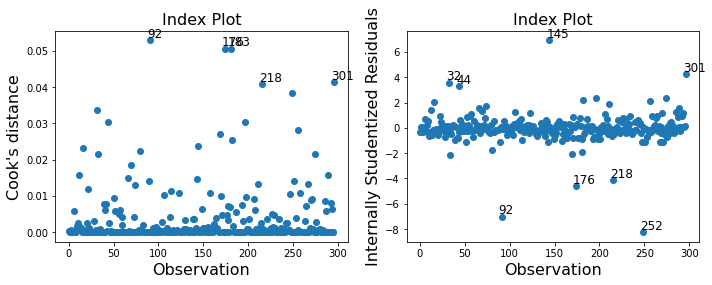

In [ ]:
#@title Diagnostic Plots
from matplotlib import pyplot as plt

infl = model.get_influence()
fig,axs = plt.subplots(1,2,figsize=(10,4))
infl.plot_index(y_var='cooks', threshold=3*4/300, ax=axs[0])
infl.plot_index(y_var='resid', threshold=3, ax=axs[1])
fig.tight_layout(pad=1.0)

## Model Comparison

Both models give similar insights and are tested against overfitting. The simpler linear model actually achieves a sligthly better F1 score ($0.83\pm 0.06$ as opposed to $0.8\pm 0.05$, on cross-validation folds). The linear model can be extended into a hierarchical model which is aware of intra-cluster effects (e.g. effects common for group of patients) and be beneficial for tasks such as sample stratification. As a side remark, the literature reports that getting close to 0.9  is very hard.


In [ ]:
model = RandomForestClassifier(n_estimators=200,max_depth=5,min_samples_leaf=10,random_state=13)
out = cross_val_score(model,X,y,scoring='f1',cv=cv)
print(out.mean().round(2),out.std().round(2))

model = LogisticRegression(max_iter=1000)
out = cross_val_score(model,X_onehot[ftrs],y,scoring='f1',cv=cv)
print(out.mean().round(2),out.std().round(2))

0.8 0.05
0.83 0.05


## Extras

In [ ]:
#@title Export summary PDF
%%capture
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#_=!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!jupyter nbconvert --no-input --template drive/MyDrive/Colab\ Notebooks/better_template --to PDF drive/MyDrive/Colab\ Notebooks/HeartDisease.ipynb --

### Improving Fit

The fit is quite good as also confirmed by the diagnostic plots. The anomalies can be skipped to improve the fit (but does not change the insights); for example the person 218 is healthy despite several risk factors: 64-old, male, high cholesterol and blocked main vessels.


                 Generalized Linear Model Regression Results                  
Dep. Variable:               hdisease   No. Observations:                  289
Model:                            GLM   Df Residuals:                      277
Model Family:                Binomial   Df Model:                           11
Link Function:                  logit   Scale:                          1.0000
Method:                          IRLS   Log-Likelihood:                -61.652
Date:                Sun, 25 Apr 2021   Deviance:                       123.30
Time:                        09:59:41   Pearson chi2:                     167.
No. Iterations:                     8                                         
Covariance Type:            nonrobust                                         
                      coef    std err          z      P>|z|      [0.025      0.975]
-----------------------------------------------------------------------------------
age                -0.1413      0.038     

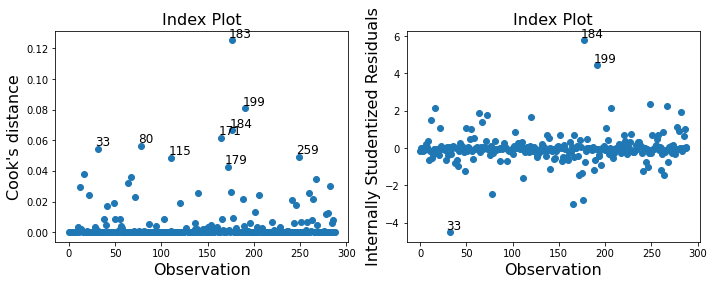

In [ ]:
#@title Improving Logistic Regression
X_onehot = X.copy(deep=True)

# see where are anomalies
blacklist = abs(infl.summary_frame()['standard_resid'])>3
df.loc[blacklist,]

vals = []
names = []
for c in cat_vars:
  val = pd.get_dummies(X_onehot[c])
  val.columns = list(map(str,val.columns))
  X_onehot = X_onehot.drop(c,axis=1)
  val = val[list(val.columns)[1:]]
  val.columns = list(map(lambda x: c+str(x),val.columns))
  vals.append(val)

X_onehot = pd.concat([X_onehot,pd.concat(vals,axis=1)],axis=1)
X_onehot['age>55'] = (X_onehot['age']>57).astype('float')
X_onehot['cholesterol>275'] = (X_onehot['cholesterol']>275).astype('float')
X_onehot['rest_bloodpress>150'] = (X_onehot['rest_bloodpress'] > 150).astype('float')
X_onehot['maxhrate>187'] = (X_onehot['maxhrate'] > 170).astype('float')

import statsmodels.api as sm
import statsmodels.formula.api  as smf
from statsmodels.tools import eval_measures

ftrs = list(X_onehot.columns)
outs = []

end = False
while not end:
  model = sm.GLM(exog=X_onehot.loc[~blacklist][ftrs], endog=y[~blacklist].astype(int), family=sm.families.Binomial())
  model = model.fit()
  worst = model.pvalues.argmax(-1)
  if model.pvalues[worst] > 0.2:
    outs.append((ftrs[worst],eval_measures.bic(model.llf,model.nobs,model.df_model)))
    ftrs.remove(ftrs[worst])
  else:
    end = True

print(model.summary())
print('start BIC=%s,end BIC=%s'%(outs[0][1],outs[-1][1]))

infl = model.get_influence()

fig,axs = plt.subplots(1,2,figsize=(10,4))
infl.plot_index(y_var='cooks', threshold=3*4/300, ax=axs[0])
infl.plot_index(y_var='resid', threshold=3, ax=axs[1])
fig.tight_layout(pad=1.0)

model = LogisticRegression(max_iter=1000)
out = cross_val_score(model,X_onehot[ftrs],y,scoring='f1',cv=5)
print(out.mean(),out.std())

## Explanatory Analysis :-)

We will have a look and see if the features discriminate the response (information-theoretically).

In [ ]:
#@title Gender Impact 
#@markdown Being a female looks like an advantage. Probably this "estrogen" conjecture.
df.groupby('sex')[['hdisease']].mean()

,hdisease
sex,
0.0,0.260417
1.0,0.557214


In [ ]:
#@title Chest Pain Impact 
#@markdown The risk goes up with pain of type 4, which is "asymptomatic" wrt anginal symptoms.
df.groupby('chestpain')[['hdisease']].mean()

,hdisease
chestpain,
1.0,0.304348
2.0,0.183673
3.0,0.216867
4.0,0.725352


In [ ]:
#@title Blood Sugar Impact 
#@markdown The sugar alone revels no information on the target. I suppose it is cousal: indirectly triggers other precise metrics.
df.groupby('bloodsugar')[['hdisease']].mean()

,hdisease
bloodsugar,
0.0,0.460630
1.0,0.465116


In [ ]:
#@title Rest ECG Impact 
#@markdown Value 1 appears with higher risk. It encodes "ST-T abnormality", so this makes sense.
df.groupby('restecg')[['hdisease']].mean()

,hdisease
restecg,
0.0,0.374150
1.0,0.750000
2.0,0.541096


In [ ]:
#@title Exercise-induced Angina Impact 
#@markdown This is a known risk factor, visible in the data.
df.groupby('exangina')[['hdisease']].mean()
	

,hdisease
exangina,
0.0,0.315000
1.0,0.762887


In [ ]:
#@title Blocked Major Vessels Impact 
#@markdown The more, the worse! Also known to the literature.
df.groupby('blockedvessels')[['hdisease']].mean()
	

,hdisease
blockedvessels,
0.0,0.258621
1.0,0.676923
2.0,0.815789
3.0,0.850000


In [ ]:
#@title Thallium Test Impact 
#@markdown The value of 3, which is the "normal reading", decreases the risk (again makes sense)
df.groupby('thallium')[['hdisease']].mean()
	

,hdisease
thallium,
3.0,0.225610
6.0,0.666667
7.0,0.765217


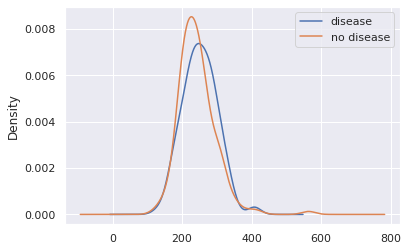

In [ ]:
#@title Cholesterol
#@markdown There is some impact from  very high cholesterol levels.
mask = df['hdisease']==True
df[mask]['cholesterol'].plot.kde(label='disease')
df[~mask]['cholesterol'].plot.kde(label='no disease')
plt.legend()

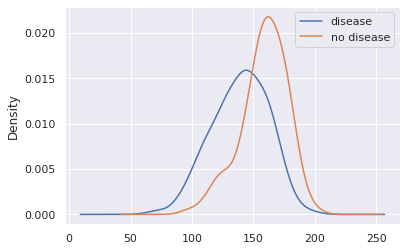

In [ ]:
#@title Max Heart Rate
#@markdown There is some impact but negative, from  the high heart rate, don't understand what is is this. I think this may have something to do with young age?
mask = df['hdisease']==True
df[mask]['maxhrate'].plot.kde(label='disease')
df[~mask]['maxhrate'].plot.kde(label='no disease')
plt.legend()

In [ ]:
#@title Export Full PDF
%%capture
from google.colab import drive
drive.mount('/content/drive', force_remount=True)
#_=!sudo apt-get install texlive-xetex texlive-fonts-recommended texlive-generic-recommended
!jupyter nbconvert --template drive/MyDrive/Colab\ Notebooks/better_template --to PDF drive/MyDrive/Colab\ Notebooks/HeartDisease.ipynb --

In [ ]:
X_onehot.loc[218]

age                     64.0
rest_bloodpress        130.0
cholesterol            303.0
maxhrate               122.0
oldpeak                  2.0
blockedvessels           2.0
sex1.0                   0.0
chestpain2.0             0.0
chestpain3.0             0.0
chestpain4.0             1.0
restecg1.0               0.0
restecg2.0               0.0
bloodsugar1.0            0.0
exangina1.0              0.0
slope2.0                 1.0
slope3.0                 0.0
thallium6.0              0.0
thallium7.0              0.0
age>55                   1.0
cholesterol>275          1.0
rest_bloodpress>150      0.0
maxhrate>187             0.0
Name: 218, dtype: float64